![*INTERTECHNICA - SOLON EDUCATIONAL PROGRAMS - TECHNOLOGY LINE*](https://solon.intertechnica.com/assets/IntertechnicaSolonEducationalPrograms-TechnologyLine.png)

# Classification Case Study: Heart Disease

*This notebook will focus on presenting the machine learning modelling for a classification problem*.

Initializing environment for machine learning use:

In [1]:
!python -m pip install numpy
!python -m pip install matplotlib
!python -m pip install sklearn

Ensure cleaner message reporting:

In [2]:
import warnings

# remove warnings for now
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

Ensure repeatable results:

In [3]:
# minimize randomness for repeatable results 
random_state = 10

## 1 Data Loading & Minimal Processing

The data exploration and preprocessing have been done in the previous sections. We will reuse these artifacts.   
We will load the processed data so that it is ready for the processing:

In [4]:
import numpy as np

field_names = ["chol", "age", "trestbps", "thalach", "oldpeak", "ca", "sex_0.0", 
               "sex_1.0", "cp_1.0", "cp_2.0", "cp_3.0", "cp_4.0", "fbs_0.0", 
               "fbs_1.0", "restecg_0.0", "restecg_1.0", "restecg_2.0", 
               "exang_0.0", "exang_1.0", "slope_1.0", "slope_2.0", "slope_3.0", 
               "thal_3.0", "thal_6.0", "thal_7.0", "diagnosis"]

# import packages for remote data load
import requests
import io

# read data remotely
data_url = "https://raw.githubusercontent.com/INTERTECHNICA-BUSINESS-SOLUTIONS-SRL/Applying-Python-in-Machine-Learning/master/notebooks/data/data_processing_processed_cleveland_data.csv"
response = requests.get(data_url)

processed_data = np.loadtxt (
    io.StringIO(response.text), 
    skiprows = 0, 
    delimiter = ",", 
    dtype = {
        "names" : field_names,
        "formats": [float] * len(field_names) 
    }
)


Let's print the first 10 records:

In [5]:
print(processed_data[0:10])

[(-0.173,  0.937,  0.816, -0.103,  1.182, -0.828, 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.)
 ( 0.821,  1.446,  1.481, -1.637,  0.712,  1.576, 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.)
 (-0.261,  1.446, -0.621, -0.937,  1.319,  1.38 , 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1.)
 ( 0.178, -1.816,  0.024,  1.926,  1.652, -0.828, 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.)
 (-0.857, -1.439,  0.024,  1.016,  0.638, -0.828, 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.)
 (-0.108,  0.104, -0.621,  1.367,  0.083, -0.828, 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.)
 ( 0.514,  0.814,  0.57 ,  0.37 ,  1.684,  1.38 , 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1.)
 ( 1.816,  0.218, -0.621,  0.524, -0.162, -0.828, 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 

Let's separate the predictor variables and the target variable: 

In [6]:
# get correct variable names
attribute_variable_names = field_names[:-1]
target_variable_name = field_names[-1]

# get attribute and target records
attributes_records = processed_data[attribute_variable_names]
target_records = processed_data[target_variable_name]

# get attributes and target records as simple array
attributes = attributes_records.view(float).reshape((attributes_records.shape[0], -1))[:, 0:-1]
target = target_records.view(float).reshape((target_records.shape[0], ))

## 2 Splitting the training and testing data sets

One of the first step in machine learning modelling is to split the data into two datasets: **one for training** and **one for testing**.  
The training data set will be used to train the model and the testing dataset will be used for validating the capabilities of the trained model.  
This is done via the **train_test_split** function from sklearn:

In [7]:
from sklearn.model_selection import train_test_split

# split the attribute and target dataset properly
x_train, x_test, y_train, y_test = train_test_split(attributes, target, random_state = random_state)

Instead of using simple splitting we will use the **cross validation** techniques.  
The training set will be used for the purpose of training (as intended), however the the test dataset will be used as a hold-out dataset for final validation.  

## 3 Selecting a classifier algorithm

The next step is selecting a classification algorithm. In sklearn there is a large palette of classifiers, so it is important to select the best one for the current problem:

In [8]:
# import several classifiers
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier

# instantiate the array of classifiers
classifiers = [
    LogisticRegression(random_state = random_state),
    SVC(random_state = random_state),
    RandomForestClassifier(random_state = random_state),
    AdaBoostClassifier(random_state = random_state),
    BaggingClassifier(random_state = random_state)    
]


The fastest way would be to train and evaluate the model on the data split we performed in the previous section. However we may have a split that is not representative.  
Ideally, we should repeat the splitting several times and train/evaluate again the model to make sure we get representative information. This is a process called cross validation.  
The sklearn library implements this **via cross_val_score** function: 

In [9]:
from sklearn.model_selection import cross_val_score, cross_validate

# cross validate each classifiers on 5 folds 
#(rule of thumb: 5 or 10 folds are good intial choices depending on the data size)
count_folds = 5
mean_accuracy = [0] * len(classifiers)
std_accuracy = [0] * len(classifiers)
for i in range(len(classifiers)) :
    # obtain the train-test
    scores = cross_val_score(classifiers[i], x_train, y_train, scoring = 'accuracy', cv = count_folds)
    mean_accuracy [i] = np.mean(scores)
    std_accuracy [i] = np.std(scores)    

Let's view the statistics of the cross validation:

In [10]:
# let's print the cross validation result
for i in range(len(classifiers)) :
    print ("{} : accuracy mean {:.3f} and accuracy std {:.3f}".format(
        type(classifiers [i]).__name__,
        mean_accuracy [i],
        std_accuracy [i]
    ))

LogisticRegression : accuracy mean 0.825 and accuracy std 0.065
SVC : accuracy mean 0.838 and accuracy std 0.031
RandomForestClassifier : accuracy mean 0.793 and accuracy std 0.045
AdaBoostClassifier : accuracy mean 0.801 and accuracy std 0.030
BaggingClassifier : accuracy mean 0.820 and accuracy std 0.051


Based on the cross validation statistics we will select the best predictor:

In [11]:
# let's select the best predictor
classifier_index = np.argsort(mean_accuracy)[-1]
classifier = classifiers[classifier_index]

print ("Selected classifier: {}".format(
        type(classifier).__name__    
))

Selected classifier: SVC


## 4 Fine tunning the classifier

Once the best classifier has been determine, we need to find the best combination of hyperparameters.  
First of all let's create the hyperparameter search space:

In [12]:
# create hyperparameter search space for various algorithms
parameters = {
    "LogisticRegression" : {
        "C" : np.logspace(-3,3,7), 
        "penalty" : ["l1","l2"]
    },
    "SVC" : {
        "C": [1, 5, 10], 
        "kernel" : ("linear", "rbf"), 
        "gamma" : ["auto", "scale"],
        "class_weight" : ["balanced", None]
    },
    "RandomForestClassifier" : {
        "n_estimators" : np.linspace(500, 1000, 3).astype(int)
    },
    "AdaBoostClassifier" : {
        "n_estimators" : np.linspace(500, 1000, 3).astype(int)
    },
    "BaggingClassifier" : {
        "n_estimators" : np.linspace(500, 1000, 3).astype(int)
    }
}

Based on the parameters search space we will determine the best classifier:

In [13]:
from sklearn.model_selection import GridSearchCV

# search for best hyperparameters for selected classifiers
best_classifier = GridSearchCV(classifier, parameters[type(classifier).__name__], refit = True, iid = False)
best_classifier.fit(x_train, y_train)
prediction = best_classifier.predict(x_test)

Let's see what is the best combination of hyperparameters:

In [14]:
print("Classifier's best parameters are: {}".format(best_classifier.best_params_))

Classifier's best parameters are: {'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}


The general model performance characteristic for the classifier are as follows:

In [15]:
from sklearn.metrics import accuracy_score, recall_score

# print basic model score
print("Accuracy score: {:.2f}".format(accuracy_score(y_test, prediction)))
print("Recall score: {:.2f}".format(recall_score(y_test, prediction)))

Accuracy score: 0.87
Recall score: 0.86


Using basic performance measurements the model seems to perform very good (close to 90% accuracy and recall).

Let's replace index label with text labels for further processing:

In [16]:
# setting labels and label the data

labels = ["Disease Present", "No Disease"]
y_test_labeled = [labels[int(i)] for i in y_test]
prediction_labeled = [labels[int(i)] for i in prediction]

The general classification report is as follows:

In [17]:
from sklearn.metrics import classification_report

# printing classification report
print(classification_report(y_test_labeled, prediction_labeled))

                 precision    recall  f1-score   support

Disease Present       0.91      0.87      0.89        47
     No Disease       0.80      0.86      0.83        28

      micro avg       0.87      0.87      0.87        75
      macro avg       0.86      0.86      0.86        75
   weighted avg       0.87      0.87      0.87        75



We can observe that the model is more precise in case of the **Disease Present** condition compared to **No Disease**. This is actually a good thing since predicting a patient healty patient with heart disease (False Positive) is better missclasifying a patient with heart disease as healthy (False Negative).  

Let's see the confusion matrix to see how the True/False Positives/Negatives are predicted by the model.

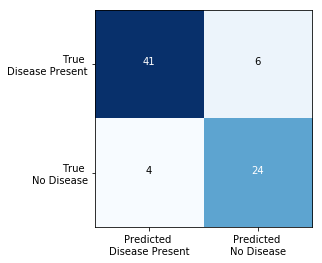

In [18]:
%matplotlib inline

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

# calculate confusion matrix
c_matrix = confusion_matrix(y_test_labeled, prediction_labeled)

# show confusion matrix data intensity
plt.imshow(c_matrix, interpolation='nearest', cmap = plt.cm.Blues)

# show labels
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, np.core.defchararray.add(["Predicted \n"] * len(labels),  labels))
plt.yticks(tick_marks, np.core.defchararray.add(["True \n"] * len(labels),  labels))

# show classification data
for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
    plt.text(j, i, format(c_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if c_matrix[i, j] > (c_matrix.max() / 2.) else "black")

plt.show()

Based on the confusion matrix the model is very good at predicting the heart disease condition and good at predicting a healthy patient. 

Finally, let's see the model resilience in predicting the **Disease Present** condition via a ROC-AUC curve:

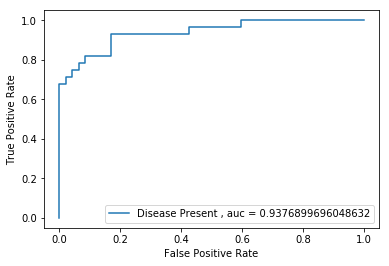

In [19]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, roc_auc_score

# we will use a calibrated classifier on top of the best classifier
# and we will retrain it in order to 
calibrated_classifier = CalibratedClassifierCV(best_classifier)
calibrated_classifier.fit(x_train, y_train)

prediction_probabilities = calibrated_classifier.predict_proba(x_test)
disease_present_prediction_probabilities = prediction_probabilities[:,1]

false_positive_rate, true_positive_rate, _ = roc_curve(y_test,  disease_present_prediction_probabilities)
auc = roc_auc_score(y_test, disease_present_prediction_probabilities)
plt.plot(false_positive_rate , true_positive_rate, label="Disease Present , auc = " + str(auc))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")


plt.legend(loc=4)
plt.show()

The **True Positive Rate** is expressed as True Positives / (True Positives + False Negatives). The **False Positive Rate** is expressed as False Positives / (False Positives + True Negatives).
The higher the area under the ROC Curve, the more resilient is the model in regards with lowering the probability threshold between **No Disease** and **Disease Present** cases.

According to the ROC-AUC analysis the model is very resilient in predicting the **Disease Present** condition. The rate of False Positives does not increase fast once the probability threshold goes down.

Overall this is a good model and definitely meeting the business challenge.